In [1]:
import sys
sys.path.append('C:/Users/32827/Documents/GitHub/BackdoorBox/')
import core
# import LIRA

C:\Users\32827\AppData\Roaming\Python\Python310\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import math
from tqdm import trange
import numpy as np
import os, sys
import pdb
from PIL import Image
from numpy import asarray
from skimage.transform import resize
import random
from art.estimators.classification import PyTorchClassifier
from art.utils import load_dataset
from torchvision.models.resnet import BasicBlock, Bottleneck
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import torchvision
import torch.nn.functional as F
from torchvision.datasets import DatasetFolder, CIFAR10

In [3]:
import numpy as np
import matplotlib.pyplot as plt

from torch import Tensor
from torch.nn import Linear, CrossEntropyLoss, MSELoss,Softmax
from torch.optim import LBFGS

from qiskit import QuantumCircuit
from qiskit.utils import algorithm_globals
from qiskit.circuit import Parameter
from qiskit.circuit.library import RealAmplitudes, ZZFeatureMap
from qiskit_machine_learning.neural_networks import SamplerQNN, EstimatorQNN
from qiskit_machine_learning.connectors import TorchConnector
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier, VQC
import torch
from torch import cat, no_grad, manual_seed
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch.optim as optim
from torch.nn import (
    Module,
    Conv2d,
    Linear,
    Dropout2d,
    NLLLoss,
    MaxPool2d,
    Flatten,
    Sequential,
    ReLU,
)
import torch.nn.functional as F
from torchvision.transforms import Compose, ToTensor, PILToTensor, RandomHorizontalFlip

In [4]:
# Prepare datasets and follow the default data augmentation in the original paper
transform_train = Compose([
    ToTensor(),
    RandomHorizontalFlip()
])
transform_test = Compose([
    ToTensor()
])

In [5]:
trainset = CIFAR10(
    root='../data', # please replace this with path to your dataset
    transform=transform_train,
    target_transform=None,
    train=True,
    download=True)

Files already downloaded and verified


In [42]:
testset = CIFAR10(
    root='../data', # please replace this with path to your dataset
    transform=transform_test,
    target_transform=None,
    train=False,
    download=True)

Files already downloaded and verified


In [43]:
trainset.data = np.transpose(trainset.data, (0, 3, 1, 2)).astype(np.int64)
testset.data = np.transpose(testset.data, (0, 3, 1, 2)).astype(np.int64)

In [8]:
idx = []
trainset.targets = np.array(trainset.targets).astype('int64')
for targets in range(4):
    classes = np.where(trainset.targets == targets)[0]
    print(classes)
    idx = np.append(idx,random.choices(classes,k = 1000))
idx = idx.astype(int)
print(idx)
trainset.data = trainset.data[idx]
trainset.targets = trainset.targets[idx]

[   29    30    35 ... 49941 49992 49994]
[    4     5    32 ... 49993 49998 49999]
[    6    13    18 ... 49987 49991 49995]
[    9    17    21 ... 49979 49982 49983]
[26493 45936 18591 ... 27317 45854 11743]


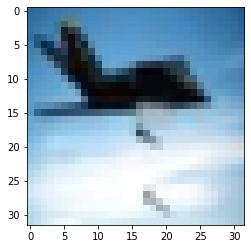

In [9]:
# Show an Example of Benign Training Samples
index = 0
x = np.expand_dims(trainset.data[index],axis=0)
# print(x[0])
img_plot = np.transpose(x[0],(1,2,0))
fig = plt.imshow(img_plot)

In [44]:
idx = []
testset.targets = np.array(testset.targets).astype('int64')
for targets in range(4):
    classes = np.where(testset.targets == targets)[0]
    # print(classes)
    idx = np.append(idx,random.choices(classes,k = 100))
idx = idx.astype(int)
# print(idx)
testset.data = testset.data[idx]
y_test = np.zeros((testset.targets[idx].size, testset.targets[idx].max() + 1))
y_test[np.arange(testset.targets[idx].size), testset.targets[idx]] = 1
testset.targets = y_test

In [11]:
class Net(Module):
    def __init__(self):
        super().__init__()
        self.conv1 = Conv2d(3, 6, 5)
        self.pool = MaxPool2d(2, 2)
        self.conv2 = Conv2d(6, 16, 5)
        self.fc1 = Linear(16 * 5 * 5, 120)
        self.fc2 = Linear(120, 84)
        # self.qnn = TorchConnector(qnn)  # Apply torch connector, weights chosen
        # uniformly at random from interval [-1,1].
        self.fc3 = Linear(84,4)  # 1-dimensional output from QNN
        # self.qnn = TorchConnector(qnn)  # Apply torch connector, weights chosen
        self.fc4 = Linear(4,4)


    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        # x = self.qnn(x)  # apply QNN
        x = self.fc4(x)
        return x


classifier_model = Net()

In [12]:
def gen_grid(height, k):
    """Generate an identity grid with shape 1*height*height*2 and a noise grid with shape 1*height*height*2
    according to the input height ``height`` and the uniform grid size ``k``.
    """
    ins = torch.rand(1, 2, k, k) * 2 - 1
    ins = ins / torch.mean(torch.abs(ins))  # a uniform grid
    noise_grid = nn.functional.upsample(ins, size=height, mode="bicubic", align_corners=True)
    noise_grid = noise_grid.permute(0, 2, 3, 1)  # 1*height*height*2
    array1d = torch.linspace(-1, 1, steps=height)  # 1D coordinate divided by height in [-1, 1]
    x, y = torch.meshgrid(array1d, array1d)  # 2D coordinates height*height
    identity_grid = torch.stack((y, x), 2)[None, ...]  # 1*height*height*2

    return identity_grid, noise_grid

In [13]:
identity_grid,noise_grid=gen_grid(32,4)

In [128]:
torch.save(identity_grid, 'CIFAR-10_WaNet_identity_grid.pth')
torch.save(noise_grid, 'CIFAR-10_WaNet_noise_grid.pth')
wanet = core.WaNet(
    train_dataset=trainset,
    test_dataset=testset,
    model=core.models.ResNet(18),
    # model=core.models.BaselineMNISTNetwork(),
    loss=nn.CrossEntropyLoss(),
    y_target=0,
    poisoned_rate=0.1,
    identity_grid=identity_grid,
    noise_grid=noise_grid,
    noise=False
)

Files already downloaded and verified
Files already downloaded and verified


In [129]:
poisoned_train_dataset, poisoned_test_dataset = wanet.get_poisoned_dataset()

In [130]:
poisoned_x_train = []
poisoned_y_train = []
poisoned_x_test = []
poisoned_y_test = []
for i in range(4000):
    x,y = poisoned_train_dataset[i]
    if y < 4 :
        poisoned_x_train.append(np.array(x))
        poisoned_y_train.append(np.array(y))
for i in range(400):
    x,y = poisoned_test_dataset[i]
    if y < 4 :
        poisoned_x_test.append(np.array(x))
        poisoned_y_test.append(np.array(y))

poisoned_x_train = np.array(poisoned_x_train)
poisoned_y_train = np.array(poisoned_y_train)
poisoned_x_test = np.array(poisoned_x_test)
poisoned_y_test = np.array(poisoned_y_test)

0


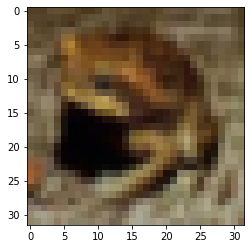

In [131]:
# Show an Example of Poison Training Samples
index = 300
x = np.expand_dims(poisoned_x_test[index],axis=0)
# print(x[0])
img_plot = np.transpose(x[0],(1,2,0))
fig = plt.imshow(img_plot)
print(poisoned_y_test[index])

In [132]:
idx = []
poisoned_y_train = np.array(poisoned_y_train).astype('int64')
for targets in range(4):
    classes = np.where(poisoned_y_train == targets)[0]
    # print(classes)
    idx = np.append(idx,random.choices(classes,k = 1000))
idx = idx.astype(int)
# print(idx)
poisoned_x_train = poisoned_x_train[idx]
y_test = np.zeros((poisoned_y_train[idx].size, poisoned_y_train[idx].max() + 1))
y_test[np.arange(poisoned_y_train[idx].size), poisoned_y_train[idx]] = 1
poisoned_y_train = y_test

In [133]:

y_test = np.zeros((poisoned_y_test.size, poisoned_y_test.max() + 1))
y_test[np.arange(poisoned_y_test.size), poisoned_y_test] = 1
poisoned_y_test = y_test

In [134]:
print("shape of x_train",poisoned_x_train.shape)
print("shape of y_train",poisoned_y_train.shape)

shape of x_train (4000, 3, 32, 32)
shape of y_train (4000, 4)


In [150]:
classifier_model.load_state_dict(torch.load("./models/normal-cifar10_mdl.pt"))

<All keys matched successfully>

In [151]:
# Pretrained model
classifier_model.eval() # for evaluation
criterion =  nn.CrossEntropyLoss()
optimizer = optim.Adam(classifier_model.parameters(), lr=0.0001)
classifier = PyTorchClassifier(model=classifier_model, 
                             nb_classes=4,input_shape=(32,32,3),loss=criterion,
                             optimizer=optimizer,device_type = 'GPU')

In [152]:
classifier_model.train()
classifier.fit(poisoned_x_train, poisoned_y_train, nb_epochs=10, batch_size=4,verbose = True)

Epochs: 100%|██████████| 10/10 [00:16<00:00,  1.62s/it]


In [153]:
class_descr = ['airplane', 'automobile', 'bird', 'cat']

In [154]:
from sklearn import metrics

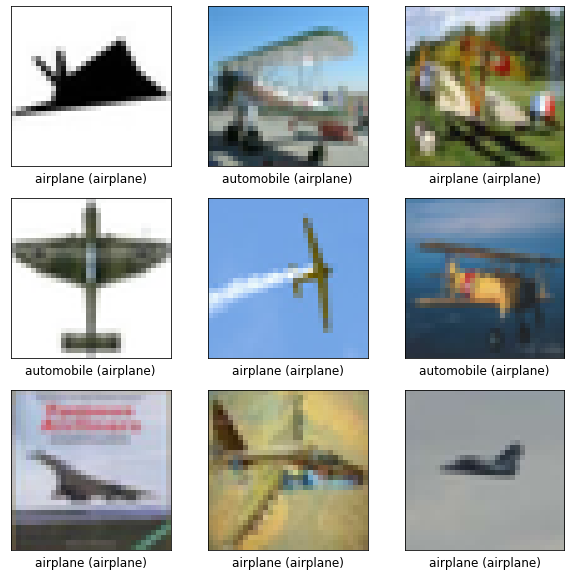

In [155]:
x_pred = np.argmax(classifier.predict(testset.data), axis=1)
# print(x_pred.shape)
# print(y_test.shape)
plt.figure(figsize=(10,10))
for i in range(0, 9):
    pred_label, true_label = class_descr[x_pred[i]], class_descr[np.argmax(testset.targets[i])]
    plt.subplot(330 + 1 + i)
    fig=plt.imshow(np.transpose(testset.data[i],(1,2,0)))
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)
    fig.axes.text(0.5, -0.1, pred_label + " (" + true_label + ")", fontsize=12, transform=fig.axes.transAxes, 
                  horizontalalignment='center')

In [156]:
print(testset.targets)

[[1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 ...
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]]


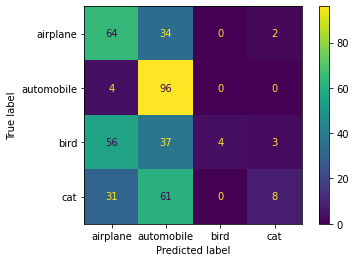

In [157]:
confusion_matrix = metrics.confusion_matrix(np.argmax(testset.targets,axis = 1), x_pred)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = class_descr)

cm_display.plot()
plt.show()

In [158]:
Accuracy = metrics.accuracy_score(np.argmax(y_test,axis=1), x_pred)
print('clean:',Accuracy)

clean: 0.3875


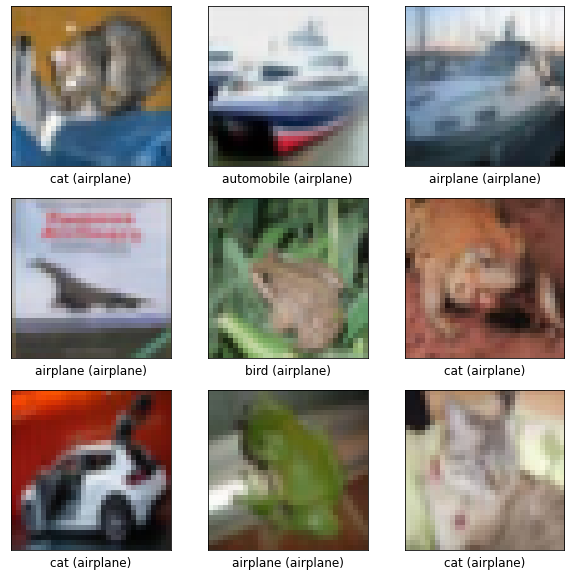

In [159]:
x_pred = np.argmax(classifier.predict(poisoned_x_test), axis=1)
# print(x_pred.shape)
# print(y_test.shape)
plt.figure(figsize=(10,10))
for i in range(0, 9):
    pred_label, true_label = class_descr[x_pred[i]], class_descr[np.argmax(poisoned_y_test[i])]
    plt.subplot(330 + 1 + i)
    fig=plt.imshow(np.transpose(poisoned_x_test[i],(1,2,0)))
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)
    fig.axes.text(0.5, -0.1, pred_label + " (" + true_label + ")", fontsize=12, transform=fig.axes.transAxes, 
                  horizontalalignment='center')

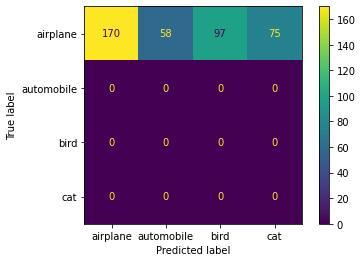

In [160]:
confusion_matrix = metrics.confusion_matrix(np.argmax(poisoned_y_test,axis=1), x_pred)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = class_descr)

cm_display.plot()
plt.show()

In [161]:
Accuracy = metrics.accuracy_score(np.argmax(poisoned_y_test,axis=1), x_pred)
print('trigger:',Accuracy)

trigger: 0.425


In [162]:
torch.save(classifier.model.state_dict(), "./models/cifar10_WaNet.pt")